In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [20]:
batch_size = 128
learning_rate = 0.00001

transforms = transforms.Compose(
[
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [21]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([128, 3, 48, 48])
out-size: torch.Size([3, 802, 402])


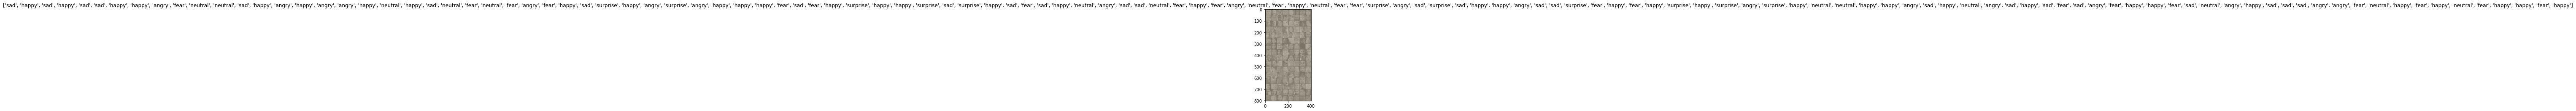

In [22]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [23]:
net = models.wide_resnet50_2(pretrained=True)
net = net.cuda() if device else net
net

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=True)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 48)
net.fc = net.fc.cuda() if device else net.fc

In [25]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'WideResnet50_adam_batch128_learninglr00005_nnlinear48_epoch30.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/221], Loss: 3.9543
Epoch [1/30], Step [20/221], Loss: 3.9943
Epoch [1/30], Step [40/221], Loss: 3.9533
Epoch [1/30], Step [60/221], Loss: 3.9044
Epoch [1/30], Step [80/221], Loss: 3.7767
Epoch [1/30], Step [100/221], Loss: 3.7989
Epoch [1/30], Step [120/221], Loss: 3.7395
Epoch [1/30], Step [140/221], Loss: 3.5032
Epoch [1/30], Step [160/221], Loss: 3.4898
Epoch [1/30], Step [180/221], Loss: 3.4124
Epoch [1/30], Step [200/221], Loss: 3.2431
Epoch [1/30], Step [220/221], Loss: 2.9233

train-loss: 3.6464, train-acc: 14.7526
validation loss: 3.0918, validation acc: 35.6728

Improvement-Detected, save-model
Epoch 2

Epoch [2/30], Step [0/221], Loss: 3.0114
Epoch [2/30], Step [20/221], Loss: 2.6806
Epoch [2/30], Step [40/221], Loss: 2.4648
Epoch [2/30], Step [60/221], Loss: 2.7505
Epoch [2/30], Step [80/221], Loss: 2.4774
Epoch [2/30], Step [100/221], Loss: 2.2612
Epoch [2/30], Step [120/221], Loss: 2.3803
Epoch [2/30], Step [140/221], Loss: 2.3635
Epoch [2/30

Epoch [14/30], Step [40/221], Loss: 0.1189
Epoch [14/30], Step [60/221], Loss: 0.0284
Epoch [14/30], Step [80/221], Loss: 0.0297
Epoch [14/30], Step [100/221], Loss: 0.0286
Epoch [14/30], Step [120/221], Loss: 0.0246
Epoch [14/30], Step [140/221], Loss: 0.0429
Epoch [14/30], Step [160/221], Loss: 0.0254
Epoch [14/30], Step [180/221], Loss: 0.0264
Epoch [14/30], Step [200/221], Loss: 0.0383
Epoch [14/30], Step [220/221], Loss: 0.0657

train-loss: 0.7543, train-acc: 99.6923
validation loss: 2.1012, validation acc: 55.0163

Epoch 15

Epoch [15/30], Step [0/221], Loss: 0.0139
Epoch [15/30], Step [20/221], Loss: 0.0370
Epoch [15/30], Step [40/221], Loss: 0.0256
Epoch [15/30], Step [60/221], Loss: 0.0249
Epoch [15/30], Step [80/221], Loss: 0.0314
Epoch [15/30], Step [100/221], Loss: 0.0156
Epoch [15/30], Step [120/221], Loss: 0.0268
Epoch [15/30], Step [140/221], Loss: 0.0305
Epoch [15/30], Step [160/221], Loss: 0.0622
Epoch [15/30], Step [180/221], Loss: 0.0327
Epoch [15/30], Step [200/221]

Epoch [27/30], Step [100/221], Loss: 0.0108
Epoch [27/30], Step [120/221], Loss: 0.0337
Epoch [27/30], Step [140/221], Loss: 0.0193
Epoch [27/30], Step [160/221], Loss: 0.0056
Epoch [27/30], Step [180/221], Loss: 0.0087
Epoch [27/30], Step [200/221], Loss: 0.0170
Epoch [27/30], Step [220/221], Loss: 0.0068

train-loss: 0.4010, train-acc: 99.7595
validation loss: 2.1617, validation acc: 55.3134

Epoch 28

Epoch [28/30], Step [0/221], Loss: 0.0090
Epoch [28/30], Step [20/221], Loss: 0.0132
Epoch [28/30], Step [40/221], Loss: 0.0112
Epoch [28/30], Step [60/221], Loss: 0.0282
Epoch [28/30], Step [80/221], Loss: 0.0061
Epoch [28/30], Step [100/221], Loss: 0.0191
Epoch [28/30], Step [120/221], Loss: 0.0081
Epoch [28/30], Step [140/221], Loss: 0.0076
Epoch [28/30], Step [160/221], Loss: 0.0182
Epoch [28/30], Step [180/221], Loss: 0.0070
Epoch [28/30], Step [200/221], Loss: 0.0409
Epoch [28/30], Step [220/221], Loss: 0.0275

train-loss: 0.3872, train-acc: 99.7383
validation loss: 2.1659, valid

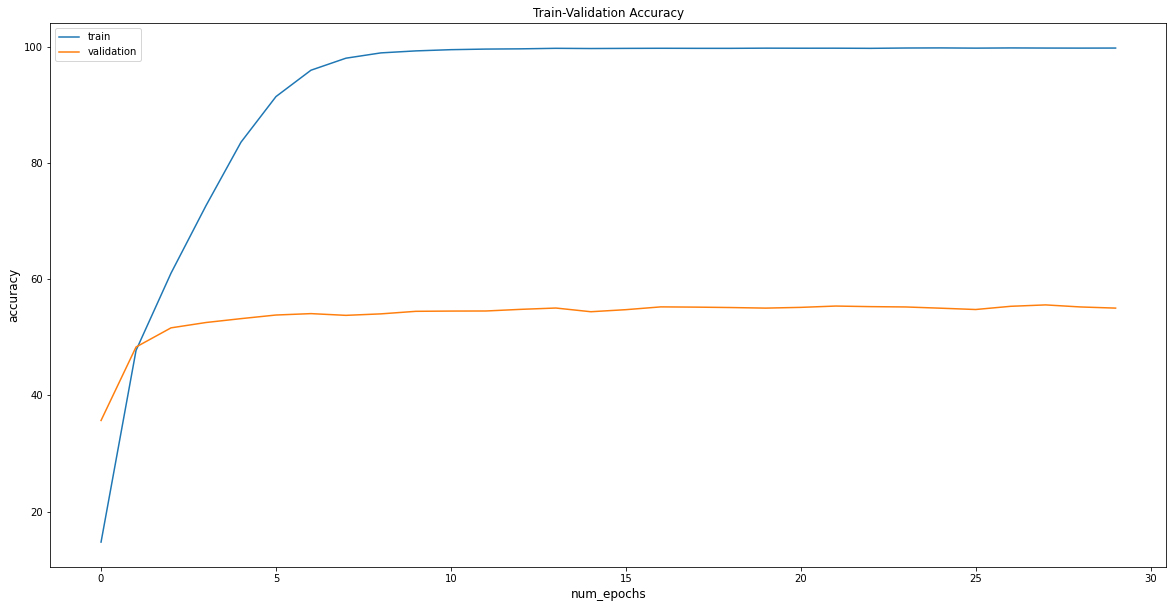

In [26]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

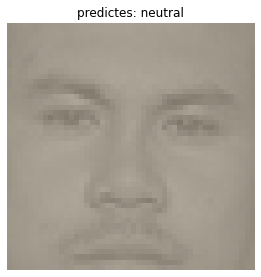

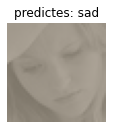

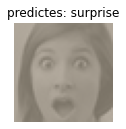

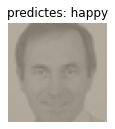

In [27]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()